In [1]:
#BA476: Using Binary Classification and Spotify Data to Predict Billboard Top 100 Placements
#Claire Choi, Rebecca Chang, Brett Rado, and Tristan Tew

import math
import pandas as pd
from google.colab import drive
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import RandomizedSearchCV
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#df = pd.read_csv('C:/Users/trist/Manipulated_data.csv')
df = pd.read_csv('/content/drive/MyDrive/BA476/data/Manipulated_data.csv')
# df = pd.read_csv('C:/Users/17327/Google Drive/BA476/data/Manipulated_data.csv')

df = df.drop(["Unnamed: 0"], axis=1)

df.shape

(6344, 337)

# Data Pre-Processing

In [3]:
#Break down all of the predictors into their respective categories
categorical_predictors = ["time_signature","key"
,"release_month","alb_type"]

#Choose these as poly features based on correlation matrix
poly_features = ["loudness","energy",'acousticness','instrumentalness']

#Create a df that has all predictors to do transformations on
all_predictors = df.loc[:, df.columns != 'target']
all_predictors

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,chorus_hit,sections,explicit,track_number,number_of_artists_on_song,release_month,genres_count,alb_type,album_tracks,pop,poprap,rap,dancepop,hiphop,trap,popdance,post-teenpop,southernhiphop,contemporarycountry,countryroad,country,atlhiphop,r&b,urbancontemporary,gangsterrap,moderncountryrock,edm,electropop,...,electricblues,azonto,frenchsoundtrack,viralrap,funkyhouse,christianrock,britpop,post-hardcore,epicdoom,calypso,classify,vaporsoul,australianindie,jazztrumpet,deeptalentshow,batonrougerap,reggaetoncolombiano,asmr,puertoricanpop,showtunes,punkblues,singer-songwriter,boombap,post-punk,easylistening,swedishjazz,exotica,candypop,bhangra,nuevoregionalmexicano,australiancountry,neo-classical,alternativecountry,symphonicblackmetal,progressivebluegrass,indiecoustica,soulfulhouse,position_on_album_ratio,duration_seconds,chorus_hit_percent
0,0.741,0.626,1,1.762331,0,11.286682,0.271442,0.000000,2.491327,0.7060,108.029,4,6.417695,2.397895,False,1.945910,1,11,8,album,2.639057,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.461538,5.239061,1.223156
1,0.447,0.247,5,2.751174,0,28.901734,0.955006,0.949852,2.358098,0.2500,155.489,3,5.760280,2.302585,False,2.302585,1,6,5,album,2.484907,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.818182,5.175472,1.194706
2,0.550,0.415,9,2.022474,0,19.230769,0.544012,0.000000,2.225624,0.2740,172.065,4,6.700110,2.302585,False,0.693147,1,9,3,single,0.693147,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000,5.325266,1.194706
3,0.502,0.648,0,1.901809,0,18.975332,0.172467,0.000000,1.589635,0.2910,91.837,4,5.433711,2.079442,True,1.098612,2,2,12,album,2.302585,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.222222,5.262913,1.124748
4,0.482,0.873,0,1.421903,1,11.723329,0.223070,0.000000,0.894040,0.7370,165.084,4,5.672126,2.564949,True,1.098612,1,11,5,album,2.833213,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.125000,5.367470,1.271150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6339,0.172,0.358,9,2.736314,1,29.239766,0.960457,0.991389,1.158362,0.0361,72.272,4,4.930339,2.079442,False,1.609438,1,8,1,single,1.945910,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.666667,5.016332,1.124748
6340,0.910,0.366,1,2.393705,1,10.626993,0.463539,0.000000,1.343235,0.7400,119.985,4,5.704258,2.197225,True,2.397895,1,12,7,album,2.833213,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.625000,5.023881,1.162283
6341,0.719,0.804,10,1.719368,1,28.169014,0.236333,0.041687,1.973281,0.6050,119.999,4,4.553428,2.079442,False,0.693147,1,3,4,album,2.995732,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.052632,5.428292,1.124748
6342,0.600,0.177,7,2.837323,1,17.825312,0.996320,0.965228,1.903809,0.5600,120.030,4,4.653279,2.708050,False,2.564949,3,8,13,album,2.772589,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.800000,5.363107,1.310506


In [4]:
#Encode each of the features while maintaining understandable column names

#Iterate through each categorical predictor
for cat in categorical_predictors:

  #Add dummy variables to the predictor df for each categorical variable and assign appropriate labels
  all_predictors = pd.concat([all_predictors,pd.get_dummies(all_predictors[cat],prefix=cat)],axis=1)

  #Drop the original categorical column from the df
  all_predictors = all_predictors.drop(columns=cat)

#Instantiate polynomial features
poly= PolynomialFeatures(2, include_bias=False)

#Apply the polynomial fit to all columns and store them in their own df
df_poly = pd.DataFrame(poly.fit_transform(all_predictors[poly_features]))

#Assign labels to the polynomial features
df_poly.columns=poly.get_feature_names(all_predictors[poly_features].columns)

In [5]:
#Drop the original variables for the poly features so there are no duplicates when df_poly and all_preds are merged
for pol in poly_features:

  #drop the poly columns
  df_poly = df_poly.drop(columns=pol)

#Create new df with all the labels
labelled_df = pd.concat([all_predictors,df_poly],axis=1)

In [6]:
#Define X and y
X = labelled_df
y = df.loc[:,'target']

#Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

In [7]:

#Standardize the Data Using StandardScaler
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#Turn the scaled numbers back into a dataframe with labels
X_scaled_train = pd.DataFrame(X_train, columns=list(X.columns.values))
X_scaled_test = pd.DataFrame(X_test, columns=list(X.columns.values))

# Baseline Model

In [ ]:
#Use SKlearn dummy as the baseline
dummy_strategies = ["stratified", "most_frequent","prior","uniform"]

best_baseline_accuracy = 0

best_strat = ''

for strat in dummy_strategies:
  #Instantiate model that will predict the majority class every time as opposed to random model
  dummy_model = DummyClassifier(strategy=strat, random_state=17)

  #Fit Model
  dummy_model.fit(X_scaled_train,y_train)

  #Predict
  y_pred_baseline = dummy_model.predict(X_scaled_test)
  y_pred_baseline_train = dummy_model.predict(X_scaled_train)

  #Define Baseline Accuracy
  baseline_accuracy = metrics.accuracy_score(y_test,y_pred_baseline)
  print("Accuracy:",baseline_accuracy,"strategy:",strat)
  if baseline_accuracy > best_baseline_accuracy:
    best_baseline_accuracy = baseline_accuracy
    best_strat = strat
    best_baseline_yhat = y_pred_baseline
    best_baseline_model = dummy_model
    best_baseline_accuracy_train = metrics.accuracy_score(y_train,y_pred_baseline_train)

Accuracy: 0.5145784081954294 strategy: stratified
Accuracy: 0.4988179669030733 strategy: most_frequent
Accuracy: 0.4988179669030733 strategy: prior
Accuracy: 0.48148148148148145 strategy: uniform


In [ ]:
#Present the best baseline model
best_baseline_accuracy, best_strat

(0.5145784081954294, 'stratified')

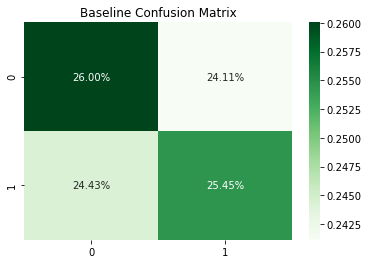

In [ ]:
#Get a confusion matrix using seaborn
matrix = metrics.confusion_matrix(y_test,best_baseline_yhat)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

plt.title('Baseline Confusion Matrix')
plt.show()

#Logistic Regression Model

In [ ]:
#Instantiate Models
p_terms = np.logspace(-5, 5, 100)
penalty = ["l2","none"]

parameter_grid = {
    'penalty': penalty,
    'C': p_terms
}

logistic_model = GridSearchCV(LogisticRegression(max_iter=10000), parameter_grid, scoring='accuracy',return_train_score=True)

#Fit Model
logistic_model.fit(X_scaled_train, y_train)

#Predict
y_pred_logistic = logistic_model.predict(X_scaled_test)
y_pred_train_log = logistic_model.predict(X_scaled_train)

#Score Train and Test
logistic_accuracy = metrics.accuracy_score(y_test,y_pred_logistic)
logistic_accuracy_train = metrics.accuracy_score(y_train,y_pred_train_log)

In [ ]:
#Print out the results
print("Test Logistic Accuracy:", logistic_accuracy)
print("Logistic Train Accuracy:", logistic_accuracy_train)
print('Best Parameters:', logistic_model.best_params_)

Test Logistic Accuracy: 0.9330181245074862
Logistic Train Accuracy: 0.9467980295566503
Best Parameters: {'C': 2.848035868435799, 'penalty': 'l2'}


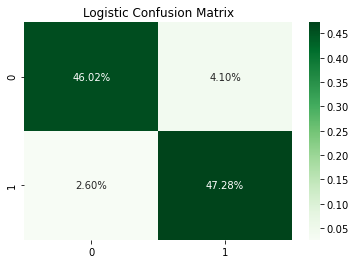

In [ ]:
#Get a confusion matrix using seaborn
matrix = metrics.confusion_matrix(y_test,y_pred_logistic)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

plt.title('Logistic Confusion Matrix')
plt.show()

In [ ]:
#Store the logistic coefficients
coef = logistic_model.best_estimator_.coef_[0]

#Get the names of the columns from one of the X sets
names = X_scaled_train.columns.values

#Create a df with the columns and coefficients to display
df = pd.DataFrame({'column name':names,'coefficient':coef})

#create a new df with the absolute value of the coefficients
df2 = pd.DataFrame({'Abs Coef':abs(df['coefficient'])})

#Sort the coefficients by largest 25 absolute values; maintain sign to see if coef is positive or negative
top_25_logistic_coefficients=pd.concat([df,df2],axis=1).sort_values(by='Abs Coef',ascending=False)[0:25]

#display top 25 coefficients
top_25_logistic_coefficients

,column name,coefficient,Abs Coef
364,loudness^2,-1.769119,1.769119
77,hollywood,1.295697,1.295697
17,pop,1.260362,1.260362
220,experimental,-1.238081,1.238081
108,chillwave,-1.149487,1.149487
28,country,1.138399,1.138399
5,acousticness,1.101333,1.101333
68,jazz,-0.868350,0.868350
257,filthstep,-0.856446,0.856446
370,energy instrumentalness,-0.852571,0.852571


#Ridge Classification Model

In [ ]:
#Also try ridgeclassifiercv to see if results are the same
lambdas = np.logspace(-5, 5, 100)

parameter_grid = {
    'alpha': lambdas,
}

#Instantiate Ridge Classifier in GridSearch across our lambda range; note that cv=none lets us use LOOCV vs k-fold
ridge_model = GridSearchCV(RidgeClassifier(),parameter_grid, scoring='accuracy',return_train_score=True)

#Fit the model
ridge_model.fit(X_scaled_train,y_train)

#Predict
ridge_yhats = ridge_model.predict(X_scaled_test)
ridge_train_yhats = ridge_model.predict(X_scaled_train)

#Use ridge_model to get the accuracy of the cross-validated model
ridge_accuracy = metrics.accuracy_score(y_test,ridge_yhats)
ridge_accuracy_train = metrics.accuracy_score(y_train,ridge_train_yhats)

In [ ]:
#Present the results
print("Ridge Test Accuracy:",ridge_accuracy)
print("Ridge Train Accuracy:",ridge_accuracy_train)
print("Best Lambda:", ridge_model.best_estimator_)

Ridge Test Accuracy: 0.9227738376674547
Ridge Train Accuracy: 0.940295566502463
Best Lambda: RidgeClassifier(alpha=475.0810162102793)


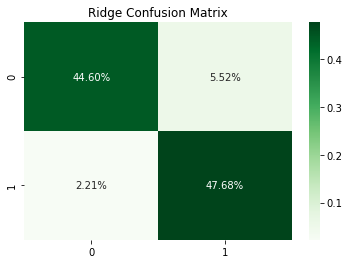

In [ ]:
#Make a confusion matrix using seaborn
matrix = metrics.confusion_matrix(y_test,ridge_yhats)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

plt.title('Ridge Confusion Matrix')
plt.show()

In [ ]:
#Store the coefficients list in a variable
coef = ridge_model.best_estimator_.coef_[0]

#Take names of predictors from our dataframe
names = X_scaled_train.columns.values

#Create a dataframe with names and coefficients to analyze importance
df = pd.DataFrame({'column name':names,'coefficient':coef})

#Also store the absolute values of all variables to see what is most important, regardless of sign
df2 = pd.DataFrame({'Abs Coef':abs(df['coefficient'])})

#Combine dfs so that absolute values and regular coefficients are stored together; take top 25 coefficients to display
top_25_ridge_coefficients=pd.concat([df,df2],axis=1).sort_values(by='Abs Coef',ascending=False)[0:25]
top_25_ridge_coefficients

,column name,coefficient,Abs Coef
17,pop,0.200134,0.200134
28,country,0.195449,0.195449
19,rap,0.149841,0.149841
45,metal,-0.129056,0.129056
6,instrumentalness,-0.102046,0.102046
150,punk,-0.101070,0.101070
133,crunk,-0.077685,0.077685
78,filmi,-0.071898,0.071898
370,energy instrumentalness,-0.070835,0.070835
361,alb_type_album,0.070616,0.070616


#Decision Trees

In [ ]:
#Instantiate
test_depths = [10,50,100,250,500,1000]
criteria = ['gini']
splitter = ['best','random']

parameter_grid = {
    'max_depth': test_depths,
    'criterion': criteria,
    'splitter': splitter
}

dt = GridSearchCV(DecisionTreeClassifier(random_state=17), parameter_grid, scoring='accuracy',return_train_score=True)

#Fit
dt.fit(X_scaled_train, y_train)

#predict 
y_hat_tree = dt.predict(X_scaled_test)
y_hat_train_tree = dt.predict(X_scaled_train)

#Check
tree_acc = metrics.accuracy_score(y_test, y_hat_tree)
tree_train_acc = metrics.accuracy_score(y_train, y_hat_train_tree)

In [ ]:
#Present results
print('Tree Test Accuracy:',tree_acc)
print('Tree Train Accuracy:',tree_train_acc)
print(dt.best_params_)

Tree Test Accuracy: 0.8896769109535066
Tree Train Accuracy: 0.9996059113300493
{'criterion': 'gini', 'max_depth': 50, 'splitter': 'random'}


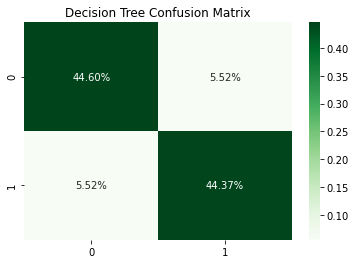

In [ ]:
#Create a confusion matrix using seaborn
matrix = metrics.confusion_matrix(y_test,y_hat_tree)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

plt.title('Decision Tree Confusion Matrix')
plt.show()

In [ ]:
#Use the feature importance method to get all of the importances in the trees
coef = dt.best_estimator_.feature_importances_


#take names for the coefficients from the df
names = X_scaled_train.columns.values

#Make a df with coefficients to measure importances
df = pd.DataFrame({'Column name':names,'Coefficient':coef}).sort_values(by='Coefficient',ascending=False)


#Display top 25 features
top_25_dt_features = df[0:25]
top_25_dt_features

,Column name,Coefficient
373,instrumentalness^2,0.349773
362,alb_type_compilation,0.056856
17,pop,0.053665
19,rap,0.043650
45,metal,0.035011
28,country,0.028070
150,punk,0.025385
145,worship,0.022838
15,genres_count,0.019125
78,filmi,0.017984


KNN

In [ ]:
neighbors = [1,3,5,10,30,50,100]
weights = ['uniform','distance']

param_grid = {
    'n_neighbors': neighbors,
    'weights': weights
}

#Instantiate
knn_model = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='accuracy',return_train_score=True)

#Fit
knn_model.fit(X_scaled_train, y_train)

#predict 
y_hat_knn = knn_model.predict(X_scaled_test)
y_hat_train_knn = knn_model.predict(X_scaled_train)

#Check
knn_acc = metrics.accuracy_score(y_test, y_hat_knn)
knn_train_acc = metrics.accuracy_score(y_train, y_hat_train_knn)

In [ ]:
#Present results
print('KNN Test Accuracy:',knn_acc)
print('KNN Train Accuracy:',knn_train_acc)
print(knn_model.best_params_)

KNN Test Accuracy: 0.8975571315996848
KNN Train Accuracy: 0.9996059113300493
{'n_neighbors': 10, 'weights': 'distance'}


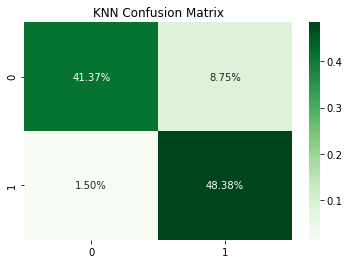

In [ ]:
#Create a confusion matrix using seaborn
matrix = metrics.confusion_matrix(y_test,y_hat_knn)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

plt.title('KNN Confusion Matrix')
plt.show()

#Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#This was our first round of hyperparameters to run through gridsearch
# depths = [1,10,50,100]
# trees = [10,100,500,1000]
# features = [10,50,100,150]

#This was our second round of hyperparameters to run through gridsearch
# depths = [20,40,60,80]
# trees = [300,500,700]
# features = ['sqrt',0.5*len(X_scaled_test.columns)),len(X_scaled_test.columns)]


depths = [25,30,35]
trees = [100,200,300]
features = ['sqrt',25,10]

param_grid = {
    'max_depth': depths,
    'max_features': features,
    'n_estimators': trees}

#Instantiate
random_forest_model = GridSearchCV(RandomForestClassifier(random_state=17), param_grid, scoring='accuracy',return_train_score=True)

#Fit
random_forest_model.fit(X_scaled_train, y_train)

#predict 
y_hat_rf = random_forest_model.predict(X_scaled_test)
y_hat_rf_train = random_forest_model.predict(X_scaled_train)

#Check
rf_acc = metrics.accuracy_score(y_test, y_hat_rf)
rf_train_acc = metrics.accuracy_score(y_train, y_hat_rf_train)

In [ ]:
#Print results
print('Test Accuracy:',rf_acc)
print('Train Accuracy:',rf_train_acc)
print(random_forest_model.best_params_)

Test Accuracy: 0.9401103230890465
Train Accuracy: 0.9996059113300493
{'max_depth': 35, 'max_features': 374, 'n_estimators': 300}


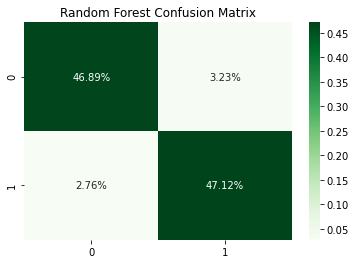

In [ ]:
#Create a confusion matrix in seaborn
matrix = metrics.confusion_matrix(y_test,y_hat_rf)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

plt.title('Random Forest Confusion Matrix')
plt.show()

In [ ]:
#Store random forest importances in a variable
coef = random_forest_model.best_estimator_.feature_importances_

#Store names of predictors in a variable
names = X_scaled_train.columns.values

#Create a dataframe with feature importances and sort by importance
df = pd.DataFrame({'Column Name':names,'Feature Importances':coef}).sort_values(by='Feature Importances',ascending=False)

#Select top 25 features to display
top_25_rf_features = df[0:25]

top_25_rf_features

,Column Name,Feature Importances
6,instrumentalness,0.131189
373,instrumentalness^2,0.130916
367,loudness instrumentalness,0.111114
17,pop,0.064438
28,country,0.047180
362,alb_type_compilation,0.046750
19,rap,0.045515
45,metal,0.027525
15,genres_count,0.021120
150,punk,0.017969


#Bagging

In [10]:
# original parameters 
# tree_list = [600,700,800]
# depths = [1,10,50,100]
# samples = [.25,.5,.75,1]

tree_list = [10]
depths = [30]
samples = [.25,.5,.75]

parameter_grid = {
    'n_estimators': tree_list,
    'base_estimator__max_depth': depths,
    'max_samples': samples
}

#Instantiate
bagging_model = GridSearchCV(BaggingClassifier(base_estimator=(DecisionTreeClassifier(random_state=17)),random_state=17), parameter_grid, scoring='accuracy',return_train_score=True)

#Fit 
bagging_model.fit(X_scaled_train,y_train)

#Predict on both test and training sets 
bagging_yhat = bagging_model.predict(X_scaled_test)
bagging_yhat_train = bagging_model.predict(X_scaled_train)

#Check accuracies for both sets
best_accuracy_bag = metrics.accuracy_score(y_test,bagging_yhat)
best_accuracy_bag_train = metrics.accuracy_score(y_train,bagging_yhat_train)

In [11]:
#Present the results
print('Test Accuracy:',best_accuracy_bag)
print('Train Accuracy:',best_accuracy_bag_train)
print(bagging_model.best_estimator_)

Test Accuracy: 0.9290780141843972
Train Accuracy: 0.9860098522167488
BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=30,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
        

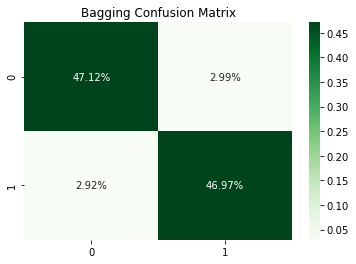

In [ ]:
#Create a confusion matrix and display using seaborn
matrix = metrics.confusion_matrix(y_test,bagging_yhat)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")


plt.title('Bagging Confusion Matrix')
plt.show()

In [ ]:
#Create a list to store bagging importances
bag_importances = []

#For each estimator in the ensemble, take the individual feature importances and average them to estimate the importance within the ensemble for each feature

for i,x in enumerate(bagging_model.best_estimator_.estimators_):
    #Add each estimator to a list to average
  bag_importances.append(bagging_model.best_estimator_.estimators_[i].feature_importances_)
  #Create a dataframe with all of the importances for each model

bag_importance_df = pd.DataFrame(bag_importances,columns=X_scaled_test.columns)

#Create a dataframe for the top 25 features

top_25_bag_features = pd.DataFrame({'Derived Feature Importance':bag_importance_df.mean().sort_values(ascending=False)[0:25]})

#Display top 25 features

top_25_bag_features

,Derived Feature Importance
instrumentalness^2,0.135061
instrumentalness,0.126435
loudness instrumentalness,0.110072
pop,0.065279
country,0.048886
rap,0.046902
alb_type_compilation,0.045935
metal,0.025807
genres_count,0.021047
punk,0.017352


#Boosting

In [ ]:
learning_params = [0.2,0.3,0.4] #try above one
tree_list = [550,650,750]
depths = [x for x in range(1,3)]

parameter_grid = {
    'n_estimators': tree_list,
    'learning_rate': learning_params,
    'base_estimator__max_depth': depths
}

#Instantiate the model

boosted_model = GridSearchCV(AdaBoostClassifier(base_estimator=(DecisionTreeClassifier(random_state=17)),random_state=17), parameter_grid, scoring='accuracy',return_train_score=True)

#Fit the model

boosted_model.fit(X_scaled_train,y_train)

#Predict on both the test and training sets

boosted_yhat = boosted_model.predict(X_scaled_test)
boosted_yhat_train = boosted_model.predict(X_scaled_train)

#Check accuracy on both the test and training sets

best_accuracy_boost = metrics.accuracy_score(y_test,boosted_yhat)
best_accuracy_boost_train = metrics.accuracy_score(y_train,boosted_yhat_train)

In [ ]:
#Present the results
print('Best Test Accuracy:',best_accuracy_boost)
print('Best Train Accuracy:',best_accuracy_boost_train)
print(boosted_model.best_estimator_)

Best Test Accuracy: 0.9377462568951931
Best Train Accuracy: 0.9980295566502463
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=17),
                   learning_rate=0.2, n_estimators=650, random_state=17)


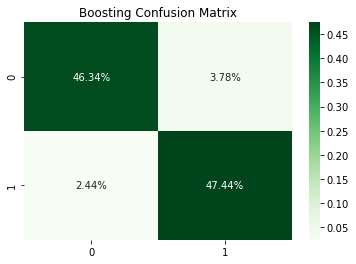

In [ ]:
#Create a confusion matrix and display in seaborn
matrix = metrics.confusion_matrix(y_test,boosted_yhat)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")


plt.title('Boosting Confusion Matrix')
plt.show()

In [ ]:
#Create a list to store the feature importances

boost_importances = []
#Run a loop for every estimator in the ensemble to get feature importances and ultimately average them

for i,x in enumerate(boosted_model.best_estimator_.estimators_):
    #Add each set of estimators to the list
  boost_importances.append(boosted_model.best_estimator_.estimators_[i].feature_importances_)

#Create a dataframe with the boosting importances and predictor names

boost_importance_df = pd.DataFrame(boost_importances,columns=X_scaled_test.columns)
#Create a dataframe that averages each feature 

top_25_boosted_features = pd.DataFrame({'Derived Feature Importance':boost_importance_df.mean().sort_values(ascending=False)[0:25]})

#Display top 25 features
top_25_boosted_features

,Derived Feature Importance
valence,0.046908
duration_seconds,0.045528
tempo,0.043910
genres_count,0.043338
liveness,0.041379
album_tracks,0.041337
chorus_hit,0.033261
danceability,0.033243
speechiness,0.032171
position_on_album_ratio,0.028373


#Stacking Classifier

In [ ]:
from sklearn.ensemble import StackingClassifier
#Store all baseline estimators in a dictionary to pass into the stacker

estimators =[('bagging', bagging_model.best_estimator_),
('rf', random_forest_model.best_estimator_),
('boost', boosted_model.best_estimator_),
('knn', knn_model.best_estimator_),
('logistic', logistic_model.best_estimator_),
('ridge', ridge_model.best_estimator_),
('dt',dt.best_estimator_)]
#Instantiate the stacker on all models

stacked_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(),cv=5)
#Fit the model 

stacked_model.fit(X_scaled_train, y_train)

#Predict on both train and testing sets

yhat_stacked = stacked_model.predict(X_scaled_test)
yhat_stacked_train = stacked_model.predict(X_scaled_train)

#Get scores for both training and testing data

stacked_acc = metrics.accuracy_score(y_test, yhat_stacked)
stacked_acc_train = metrics.accuracy_score(y_train, yhat_stacked_train)

In [ ]:
#Present the results
print('Best Test Accuracy:',stacked_acc)
print('Best Train Accuracy:',stacked_acc_train)


Best Test Accuracy: 0.9440504334121356
Best Train Accuracy: 0.9982266009852216


<AxesSubplot:>

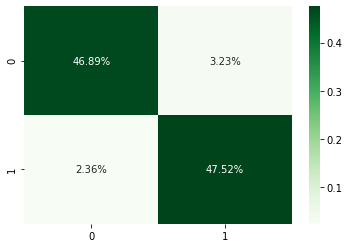

In [ ]:
#Use seaborn to display a confusion matrix

matrix = metrics.confusion_matrix(y_test,yhat_stacked)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

#ROC Curve Comparison

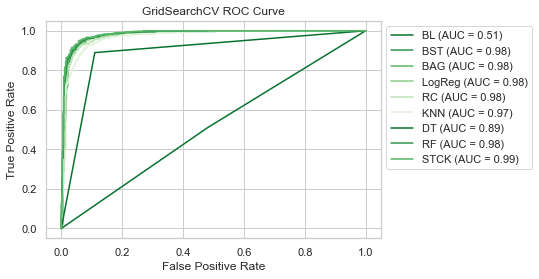

In [ ]:
#List all of the best models
modelset = [best_baseline_model,boosted_model,bagging_model,logistic_model,ridge_model,knn_model,dt,random_forest_model,stacked_model]
model_names = ['BL','BST','BAG','LogReg','RC','KNN','DT','RF','STCK']

#Define the colors for the chart 

sns.set(palette="Greens_r",style='whitegrid')

#Set up the model to stack plots for each classifier

axis = plt.gca()

#iterate through all models

for i,met in enumerate(modelset):
    #Plot the ROC curve for a given model

  metrics.plot_roc_curve(met,X_scaled_test,y_test,ax=axis,name=model_names[i])
 
  #Add legend and title to chart to finish it off

  plt.legend(bbox_to_anchor=(1, 1))
  plt.title('GridSearchCV ROC Curve')
plt.show()

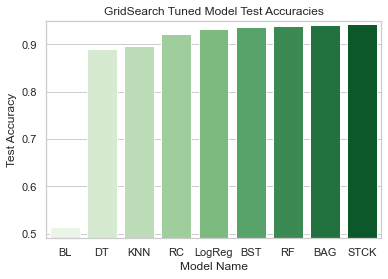

In [ ]:
#Store all accuracy scores for the test set
accuracies= [best_baseline_accuracy,logistic_accuracy,ridge_accuracy,tree_acc,knn_acc,rf_acc,best_accuracy_boost,best_accuracy_bag,stacked_acc]

#Store all accuracies for the training set
train_accuracies = [best_baseline_accuracy_train,logistic_accuracy_train,ridge_accuracy_train,tree_train_acc,knn_train_acc,rf_train_acc,best_accuracy_boost_train,best_accuracy_bag_train,stacked_acc_train]

#Store all names of the classifiers
model_names = ['BL','LogReg','RC','DT','KNN','RF','BST','BAG','STCK']

#Create a dataframe that stores the names and accuracies; sort by test accuracy 
models = pd.DataFrame({'Model Name':model_names,'Test Accuracy':accuracies,'Train Accuracy':train_accuracies}).sort_values(by='Test Accuracy')

#Set the plot palette to spotify green

sns.set(palette="Greens_r",style='whitegrid')

#Create a barplot that shows the test accuracies ranked by name; adjust min and max to be closer to min and max of set 
sns.barplot(y=models['Test Accuracy'],x=models['Model Name'],palette='Greens').set_ylim(.49,.95)

#Add a title
plt.title('GridSearch Tuned Model Test Accuracies')
plt.show()

In [ ]:
#Create a new column on the dataframe to show the differences between train/test and understand how much all of our models overfit
models['Difference'] = models['Test Accuracy'] - models['Train Accuracy']

#Sort by test accuracy and display
models.sort_values(by='Test Accuracy', ascending=False)

,Model Name,Test Accuracy,Train Accuracy,Difference
8,STCK,0.944050,0.998227,-0.054176
7,BAG,0.940898,0.999606,-0.058708
5,RF,0.940110,0.999606,-0.059496
6,BST,0.937746,0.998030,-0.060283
1,LogReg,0.933018,0.946798,-0.013780
2,RC,0.922774,0.940296,-0.017522
4,KNN,0.897557,0.999606,-0.102049
3,DT,0.889677,0.999606,-0.109929
0,BL,0.514578,0.508177,0.006401
